## MA506 Probability and Statistical Inference
## Lecture 19: Model Selection for Ridge Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Model selection for ridge regression models

Once we fix the X matrix, finding the best ridge regression model boils down to finding the best hyperparameter $\lambda$. This forms the topic for the current lecture. Recalling the standard ridge regression formulation:

$$
\min_{\beta}\frac{1}{n}||Y-X\beta||_2^2, \text{ such that }||\beta||_2^2 \leq c^2
$$

the parameter set $\beta$ has the representation:
$$
\beta = (X^TX + n \lambda I)^{-1}X^TY
$$

An ideal $\beta$ should have a value of $\lambda$ that is

1. **Neither too big**: As very large $\lambda$ will reduce the flexibility of the model and it will not learn any structure. Essentially it would be underfitting.
2. **Neither too small**: As a very small $\lambda$ might make it similar to linear regression with high flexibility and prone to overfitting.

## Generate some data

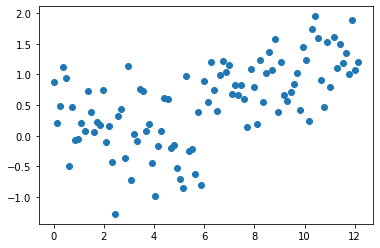

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
x = np.linspace(0,12.14,100)
y = np.ones([len(x)])
y[x<6] = 0
err = np.random.randn(len(x))*0.5
y_noisy = y+err
plt.scatter(x,y_noisy)
plt.show()

In [3]:
def poly_power(x,n):
    X = []
    for i in x:
        temp = []
        for j in range(n+1):
            temp.append(i**j)
                
        X.append(temp)
    return np.array(X)
X = poly_power(x,n = 7)

In [4]:
lambda_small = 1.0e-10
beta_small = np.linalg.inv(X.T.dot(X) + X.shape[0]*lambda_small*np.eye(X.shape[1])).dot(X.T.dot(y_noisy))
pred_small = X.dot(beta_small)


lambda_big = 1.0e+10
beta_big = np.linalg.inv(X.T.dot(X) + X.shape[0]*lambda_big*np.eye(X.shape[1])).dot(X.T.dot(y_noisy))
pred_big = X.dot(beta_big)

lambda_mid = 0.01
beta_mid = np.linalg.inv(X.T.dot(X) + X.shape[0]*lambda_mid*np.eye(X.shape[1])).dot(X.T.dot(y_noisy))
pred_mid = X.dot(beta_mid)


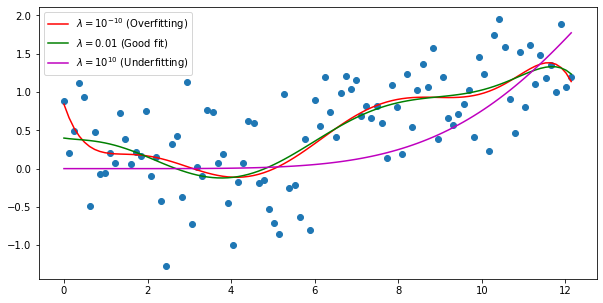

In [5]:
fig = plt.figure(figsize=(10,5))

plt.scatter(x,y_noisy)
plt.plot(x,pred_small,color = 'r', label = '$\lambda = 10^{-10}$ (Overfitting)')
plt.plot(x,pred_mid,color = 'g', label = '$\lambda = 0.01$ (Good fit)')
plt.plot(x,pred_big,color = 'm', label = '$\lambda = 10^{10}$ (Underfitting)')
plt.legend()
plt.show()

**Hence there is some good $\lambda$ which is neither too small nor too big!!!**

Here we discuss 2 metric which can be optimized to find a good $\lambda$

## 1. Cross Validation

Cross Validation (CV) essentially tries to find the $\lambda$ value that minimizes the following metric:

$$
CV(\lambda) = \frac{1}{n} \sum_{i = 1}^n (y_i - \hat{y}_i^{-i})^2 \tag{1}
$$

Here
- $y_i$: y value of the $i^{th}$ data point in the dataset
- $\hat{y}_i^{-i}$: y value predicted at x value of $i^{th}$ datapoint when $i^{th}$ datapoint was not used for model fitting (computing $\beta$)

However, instead of fitting $n$ models which would be very expensive, we consider an alternate representation of CV.

$$
CV(\lambda) = \frac{1}{n} \sum_{i=1}^n \Bigg(\frac{y_i - \hat{y}_i}{1 - H_{\lambda}^{ii}} \Bigg)^2 \tag{2}
$$

Here
- $y_i$: y value of the $i^{th}$ data point in the dataset
- $\hat{y}_i$: predicted y value at the x location of the $i^{th}$ data point
- $H_{\lambda}^{ii}$: $i^{th}$ diagonal value of the hat matrix $H_{\lambda} = X(X^TX + n \lambda I)^{-1}X^T$.

**Best $\lambda$ would be the one that minimizes (2)** 

## 2. Generalized Cross Validation

Generalized Cross Validation is a more stable version of Cross Validation and is defined as

$$
GCV(\lambda) = \frac{1}{n} \sum_{i=1}^n \Bigg(\frac{y_i - \hat{y}_i}{1 - tr(H_{\lambda})/n} \Bigg)^2
$$

Here
- $tr(H_{\lambda})$ is the sum of diagonal elements of $H_{\lambda}$ (commonly referred to as the trace of a matrix)

In [6]:
def CV(lam,X,y):
    beta = np.linalg.inv(X.T.dot(X) + X.shape[0]*lam*np.eye(X.shape[1])).dot(X.T.dot(y))
    yhat = X.dot(beta)
    H = X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
    s = 0
    for i in range(len(y)):
        term = (y[i] - yhat[i])/(1 - H[i,i])
        s = s + term**2
    return s/len(y)

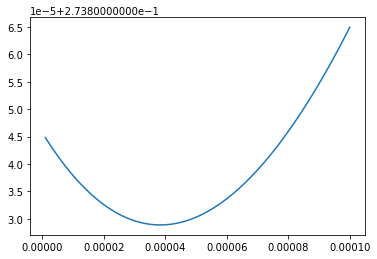

In [8]:
lam = np.linspace(1.0e-6, 1.0e-4,100)
cv = [CV(i,X,y_noisy) for i in lam]
plt.plot(lam,cv)
plt.show()

In [9]:
def optimize_lamCV(X,y,lam):
    args = (X,y)
    bnds = [(1.0e-20, None)]
    lamb = [lam]
    lam = minimize(CV,lamb,args,bounds=bnds,method='SLSQP')
    return lam

In [10]:
optimize_lamCV(X,y_noisy,lam = 0.1)

     fun: 0.27382897575127385
     jac: array([-0.00312686])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([4.15951877e-05])

In [11]:
def GCV(lam,X,y):
    beta = np.linalg.inv(X.T.dot(X) + X.shape[0]*lam*np.eye(X.shape[1])).dot(X.T.dot(y))
    yhat = X.dot(beta)
    H = X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
    h = np.mean(np.diag(H)) 
    s = 0
    for i in range(len(y)):
        term = (y[i] - yhat[i])/(1 - h)
        s = s + term**2
    return s/len(y)

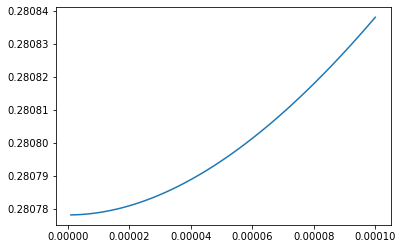

In [12]:
lam = np.linspace(1.0e-6, 1.0e-4,100)
cv = [GCV(i,X,y_noisy) for i in lam]
plt.plot(lam,cv)
plt.show()

In [13]:
def optimize_lamGCV(X,y,lam):
    args = (X,y)
    bnds = [(1.0e-12, None)]
    lamb = [lam]
    lam = minimize(GCV,lamb,args,bounds=bnds,method='SLSQP')
    return lam

In [14]:
optimize_lamGCV(X,y_noisy,lam = 0.1)

     fun: 0.28077816768298275
     jac: array([0.00010638])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000563e-12])

In [15]:
GCV(1.00000563e-12,X,y)

0.022074912504231242